In [ ]:
#Install the necessary packages

!pip install yfinance
!pip install matplotlib==3.5.3
!pip install arch

In [90]:
#Standard packages
import numpy as np
import pandas as pd

#Dates
from datetime import datetime, timedelta

#Finance packages
import yfinance as yf
from arch import arch_model

#Statistics
from scipy.stats import t
from scipy.stats import skew, kurtosis

#Plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from matplotlib import rcParams

rcParams["font.size"] = 10
rcParams["axes.labelsize"] = 20

rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16

rcParams["figure.figsize"] = (8,6)

# Exercise 1. Analysis of the S&P 500 volatility time-series

**1. Download the data**

In [91]:
start = datetime(1997, 1, 1)
end = datetime.today()

assets = "^GSPC"

df = yf.download(assets, start=start, end=end, progress=False)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-01-02,740.739990,742.809998,729.549988,737.010010,737.010010,463230000
1997-01-03,737.010010,748.239990,737.010010,748.030029,748.030029,452970000
1997-01-06,748.030029,753.309998,743.820007,747.650024,747.650024,531350000
1997-01-07,747.650024,753.260010,742.179993,753.229980,753.229980,538220000
1997-01-08,753.229980,755.719971,747.710022,748.409973,748.409973,557510000


**2. Compute the log returns and the moving volatility of log returns**

**Clue:** *The pandas.Series.rolling(window).statistic() method computes the moving version of the chosen statistic over the given window size through all the series.*

**Example**: *df["Col1"].rolling(100).mean()*

In [92]:
window = 25

df["LogRet"] = np.log(1 + df["Adj Close"].pct_change())
df["MV"] = df["LogRet"].rolling(25).std()


df

,Open,High,Low,Close,Adj Close,Volume,LogRet,MV
Date,,,,,,,,
1997-01-02,740.739990,742.809998,729.549988,737.010010,737.010010,463230000,NaN,NaN
1997-01-03,737.010010,748.239990,737.010010,748.030029,748.030029,452970000,0.014842,NaN
1997-01-06,748.030029,753.309998,743.820007,747.650024,747.650024,531350000,-0.000508,NaN
1997-01-07,747.650024,753.260010,742.179993,753.229980,753.229980,538220000,0.007436,NaN
1997-01-08,753.229980,755.719971,747.710022,748.409973,748.409973,557510000,-0.006420,NaN
...,...,...,...,...,...,...,...,...
2024-03-28,5248.029785,5264.850098,5245.819824,5254.350098,5254.350098,3998270000,0.001116,0.005716
2024-04-01,5257.970215,5263.950195,5229.200195,5243.770020,5243.770020,3325930000,-0.002016,0.005752
2024-04-02,5204.290039,5208.339844,5184.049805,5205.810059,5205.810059,3886590000,-0.007265,0.005917


**3. Plot the returns together with the returns +- the moving volatility and the returns +- the std deviation (horizontal line). Plot also the moving volatility alone. What do you observe?**

**Clue**: *Basically I ask you to reproduce the figure I uploaded to UIB digital (contact me if you don't find it)*

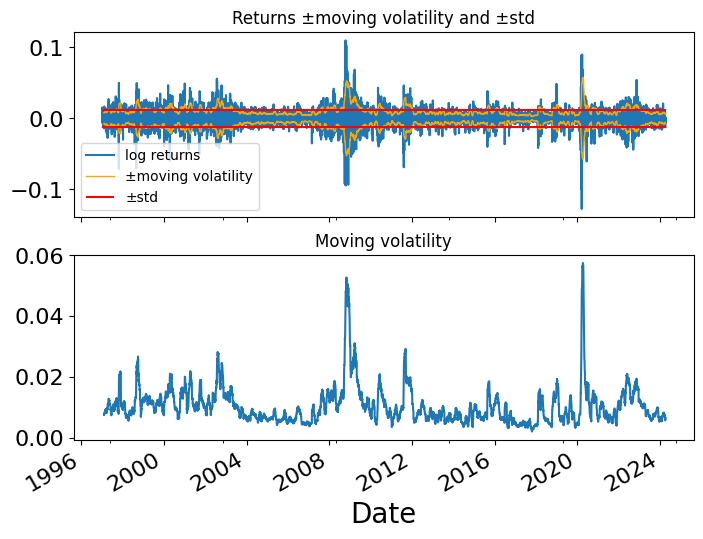

In [93]:
df["-MV"]= -df["MV"] # This extra column is needed fot the plot
av_ret = df.LogRet.std()

fig, ax = plt.subplots(2,1, sharex=True)

# First plot (returns ±moving volatility and ±std)
df.LogRet.plot(ax=ax[0], label='log returns')
df.MV.plot(ax=ax[0] ,lw=1 ,color='orange' ,label='±moving volatility')
df["-MV"].plot(ax=ax[0] ,lw=1 ,color='orange',label='')
ax[0].hlines(y=[av_ret,-av_ret],xmin=start, xmax=end, color='r', label='±std')
ax[0].legend()
ax[0].set_title('Returns ±moving volatility and ±std')

# Second plot, moving volatility alone
df.MV.plot(ax=ax[1],label='moving volatility')
ax[1].set_title('Moving volatility')

plt.show()

# Exercise 2. Volatility forecast with an ARCH model

ARCH stands for autoregressive conditional heteroskedasticity, which basically means that the variance of the underlaying stochastic process changes in time (heteroskedasticity).

An ARCH(p) model is constructed by considering random increments $x$ (usually gaussian) with zero mean and variance $\sigma(t_j)=\sigma_j$ modelled trhough an autoregressive process

\begin{equation}
\sigma_j^2=\alpha_o+\alpha_1 x_{j-1}^2+\dots+\alpha_{p} x_{j-p}^2
\end{equation}

To determine the appropriate number of lags to use (value of $p$) we will use some statistical metrics for model selection: the Akaike information criterion (AIC) and the Bayesian Information Criterion (BIC). Both are estimators of prediction error and thereby relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC and BIC estimate the quality of each model, relative to each of the other models. Thus, they provide a mean for model selection.

The AIC for a given model $\mathcal{M}$ is computed as

\begin{equation}
AIC_{\mathcal{M}} = 2k-2\ln(\hat{L})
\end{equation}

where $k$ is the number of parameters of the model and $\hat{L}$ is the maximized value of the likelihood function for the model.

The BIC for a given model $\mathcal{M}$ is computed as

\begin{equation}
BIC_{\mathcal{M}} = k\ln(n)-2\ln(\hat{L})
\end{equation}

where $k$ is the number of parameters of the model, $n$ is the number of data points used in the fit and $\hat{L}$ is the maximized value of the likelihood function for the model.

As you can see in the formulas above, larger likelihood functions (best-fits) contribute to minimise the criteria, but there is a penalty included by the number of the parameters of the model. This is indeed the point of this criteria, maximise the goodness of the fit while minimising the number of parameters used.

**Take home message:** *smaller values of AIC and BIC correspond to better models.*

**1. Fit an ARCH model**

Chose a particular value of $p$ to fit an ARCH model to the data. Analyze the output carefulluy to understand how the library works.

In [94]:
#We have to remove the NaNs for the model to work and we rescale the data for better predictions (otherwise a warning shows up)
df_fit = df.dropna() * 100

returns = df_fit['LogRet']

am = arch_model(returns, p=5, o=0, q=0,)

res = am.fit()

print("\n")

res.summary()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 47367.39353714981
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16410.140170422754
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1190432.705532828
Iteration:      4,   Func. Count:     42,   Neg. LLF: 1665680.444834991
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4542416.541610201
Iteration:      6,   Func. Count:     60,   Neg. LLF: 74973.38272284988
Iteration:      7,   Func. Count:     69,   Neg. LLF: 5739516.4430618
Iteration:      8,   Func. Count:     78,   Neg. LLF: 14142.726998503102
Iteration:      9,   Func. Count:     87,   Neg. LLF: 11677.186553226451
Iteration:     10,   Func. Count:     96,   Neg. LLF: 10458.879575353674
Iteration:     11,   Func. Count:    106,   Neg. LLF: 9928.88886164551
Iteration:     12,   Func. Count:    115,   Neg. LLF: 11791.212434248804
Iteration:     13,   Func. Count:    124,   Neg. LLF: 9731.715291005947
Iteration:     14,   Func. Count:    132,   Neg. LLF: 9730.561

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 LogRet   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9730.18
Distribution:                  Normal   AIC:                           19474.4
Method:            Maximum Likelihood   BIC:                           19522.2
                                        No. Observations:                 6834
Date:                Thu, Apr 04 2024   Df Residuals:                     6833
Time:                        20:08:51   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0689  1.021e-02      6.749  1.494e-11 [4.891e-02,8.894e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3138  2.421e-02     12.963  1.982e-38   [  0.266,  0.361]
alpha[1]       0.1132  2.122e-02      5.335  9.558e-08 [7.163e-02,  0.155]
alpha[2]       0.2176  2.339e-02      9.304  1.352e-20   [  0.172,  0.263]
alpha[3]       0.1681  2.131e-02      7.887  3.092e-15   [  0.126,  0.210]
alpha[4]       0.1864  2.272e-02      8.205  2.302e-16   [  0.142,  0.231]
alpha[5]       0.1376  1.959e-02      7.023  2.175e-12 [9.920e-02,  0.176]
==========================================================================

Covariance estimator: robust
"""

**2. Determine the optimal value for $p$**

Fit the model using different values of p (e.g. 1 to 25) and compute their AIC and BIC values to determine the optimal value for $p$.

**Indication:** *Use `am.fit(disp=False)` to deactivate the printing of fit messages*

**Clue:** *The `res.aic` and `res.bic` methods return the AIC and BIC values for the fitted model.*

In [95]:
df_fit = df.dropna() * 100
returns = df_fit['LogRet']

min_aic = 1e10    # We give huge initial values to AIC and BIC to make sure some real
min_bic = 1e10    # value is acually lower
for i in range(1,26):
  am = arch_model(returns, p=i, o=0, q=0,)
  res = am.fit(disp=False)
  aic = res.aic
  bic = res.bic
# print(f"p={i:2}: AIC={aic:.1f}, BIC={bic:.1f}")
  # We make an if statment that will end up saving the lowest values and its indices
  if aic < min_aic:
    min_aic = aic
    p_min1 = i
  if bic < min_bic:
    min_bic = bic
    p_min2 = i
print(f"Optimal p value according to AIC: {p_min1:2}")
print(f"Optimal p value according to BIC: {p_min2:2}")

Optimal p value according to AIC: 19
Optimal p value according to BIC: 11


**3. Forecasts using optimal model**

Use the `forecasts = res.forecast(horizon=1, start=0, reindex=True, align=target)` method to compute the predicted volatility in the sample. You can obtain the forecasted variance as `forecasts.variance`.

Plot the predictions along with the moving volatility previously predicted. Do you think the model is performing well?

*If you are curious on what the arguments of this function are, check it out at https://arch.readthedocs.io/en/latest/*

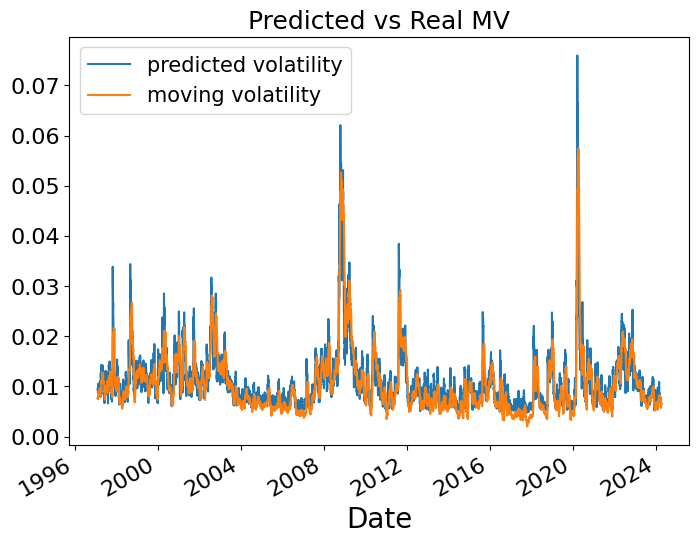

In [96]:
rcParams["font.size"] = 15
# For simplicity I chose p=11, as the optimal p-value according to BIC
am = arch_model(returns, p=11, o=0, q=0)
res = am.fit(disp=False)
forecasts = res.forecast(horizon=1, start=0, reindex=True, align='target')
df_pred = forecasts.variance                       # Save the predicted variance in a df
df_pred["MV_pred"] = np.sqrt(df_pred['h.1'])/100   # Calculate the std in order to compare with our data

df_pred['MV_pred'].plot(label='predicted volatility')
df.MV.plot(label='moving volatility')
plt.legend()
plt.title('Predicted vs Real MV')
plt.legend()
plt.show()


L'ajust del model és molt bo encara que preveu una volatilitat lleugerament major que la real en la majoria dels casos.

# Exercise 3. Volatility forecast with GARCH models

To fit a GARCH model you just have to select $p,q\neq0$ in the arch_model(returns, p, o, q) function

**1. Fit a GARCH model**

In [97]:
am = arch_model(returns, p=1, o=0, q=1)

res = am.fit()

print("\n")

print(res.summary)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 576173494903628.0
Iteration:      2,   Func. Count:     15,   Neg. LLF: 524780791.94609094
Iteration:      3,   Func. Count:     22,   Neg. LLF: 13534.832659391826
Iteration:      4,   Func. Count:     29,   Neg. LLF: 9820.94604246724
Iteration:      5,   Func. Count:     35,   Neg. LLF: 9664.400797835206
Iteration:      6,   Func. Count:     41,   Neg. LLF: 9605.737545477623
Iteration:      7,   Func. Count:     47,   Neg. LLF: 9694.08234625581
Iteration:      8,   Func. Count:     53,   Neg. LLF: 9589.696737466906
Iteration:      9,   Func. Count:     58,   Neg. LLF: 9589.699505815726
Iteration:     10,   Func. Count:     64,   Neg. LLF: 9589.62835153702
Iteration:     11,   Func. Count:     69,   Neg. LLF: 9589.627687244141
Iteration:     12,   Func. Count:     74,   Neg. LLF: 9589.62768668408
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9589.62768668408
            Iterations: 12
    

**2. Determine the optimal values for $p$ and $q$**

Same as before, but with 2 parameters. Plot the results in a 2D plot (imshow, matshow, pcolormesh, contourf, whatever)

**Note:** *This will take a while as you now have to search for 2 optimal parameters.*

In [98]:
df_fit = df.dropna() * 100
returns = df_fit['LogRet']

aics = np.eye(5)      # We create a 2D array to store the diferent AIC values
for i in range(1,6):
  for k in range(1,6):
    am = arch_model(returns, p=i, o=0, q=k,)
    res = am.fit(disp=False)
    aic = res.aic
    aics[i-1,k-1]=aic

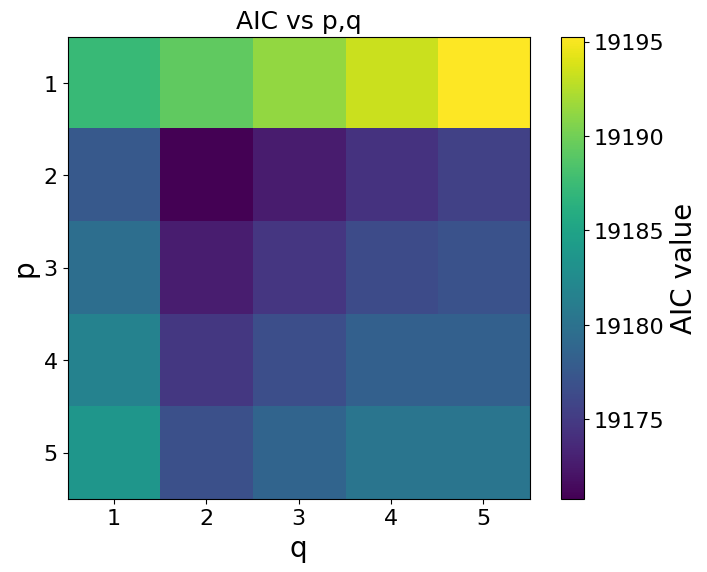

In [99]:
tiks_labels = [1,2,3,4,5]     # Needed this otherwise p and q apear to go from 0 to 4
tiks_pos = [0,1,2,3,4]        # Need to specify position when tick labels are changed
plt.imshow(aics, interpolation='none')
plt.colorbar(label='AIC value')         # We add a nice colorbar to understand the bic values

plt.xlabel('q')
plt.xticks(tiks_pos,tiks_labels)
plt.ylabel('p')
plt.yticks(tiks_pos,tiks_labels)
plt.title('AIC vs p,q')
plt.show()

The optimal parameters are p=2 and q=2

**3. Forecasts**

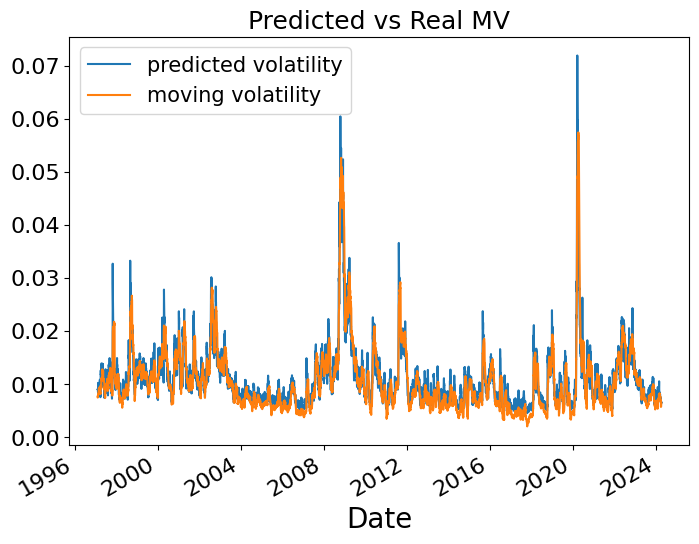

In [100]:
# We simply repeat the process of the last exercice changing p and q values
am = arch_model(returns, p=2, o=0, q=2)
res = am.fit(disp=False)
forecasts = res.forecast(horizon=1, start=0, reindex=True, align='target')
df_pred = forecasts.variance                       # Save the predicted variance in a df
df_pred["MV_pred"] = np.sqrt(df_pred['h.1'])/100   # Calculate the std in order to compare with our data


df_pred['MV_pred'].plot(label='predicted volatility')
df.MV.plot(label='moving volatility')
plt.legend()
plt.title('Predicted vs Real MV')
plt.legend()
plt.show()

Podem veure que l'ajust és molt semblant a l'ARCH, però lleugerament millor.

**4. ARCH or GARCH?**

Compare the best fit models $ARCH(p^*)$ and $GARCH(p^*,q^*)$ to determine which is the overall best one.

In [107]:
# To compare model fit so far we've learned about two criteria, AIC and BIC
df_fit = df.dropna() * 100
returns = df_fit['LogRet']

res_garch = arch_model(returns, p=2, o=0, q=2).fit(disp=False)
g_aic = res_garch.aic
g_bic = res_garch.bic
res_arch  = arch_model(returns, p=11, o=0, q=0).fit(disp=False)
a_aic = res_arch.aic
a_bic = res_arch.bic

print(f"GARCH(2,2)  has values: BIC={g_bic:.0f}, AIC={g_aic:.0f}")
print(f"ARCH(11)    has values: BIC={a_bic:.0f}, AIC={a_aic:.0f}")


GARCH(2,2)  has values: BIC=19212, AIC=19171
ARCH(11)    has values: BIC=19290, AIC=19201


Ja que un menor valor de BIC o AIC indica una millor ajust com a model, podem concloure que el GARCH(2,2) és millor que el ARCH(11).

# Exercise 4. Simulation of ARCH and GARCH processes

**1. Simulate price dynamics with an ARCH and GARCH model**

We will use the ARCH(11) and GARCH(2,2) models, as we previously found that these were the optimal parameters.

In [102]:
N_steps = 10**4

# Scale the returns (multiplying by 100) for a propper fit
returns_scaled = df['LogRet'].dropna()*100

# Perform the fit
params_arch = arch_model(returns_scaled, p=11, o=0, q=0).fit(disp=False).params
params_garch = arch_model(returns_scaled, p=2, o=0, q=2).fit(disp=False).params

# Scale back the returns (dividing by 100)
sim_arch = arch_model(None, p=11, o=0, q=0).simulate(params_arch, N_steps) / 100
sim_garch = arch_model(None, p=2, o=0, q=2).simulate(params_garch, N_steps) / 100

S_0 = df.iloc[-1]["Adj Close"]

S_t_arch = S_0*np.exp(np.cumsum(sim_arch['data']))      # We convert the simulated returns data into prices
S_t_garch = S_0*np.exp(np.cumsum(sim_garch['data']))


**2. Plot the simulated returns, volatility and prices**

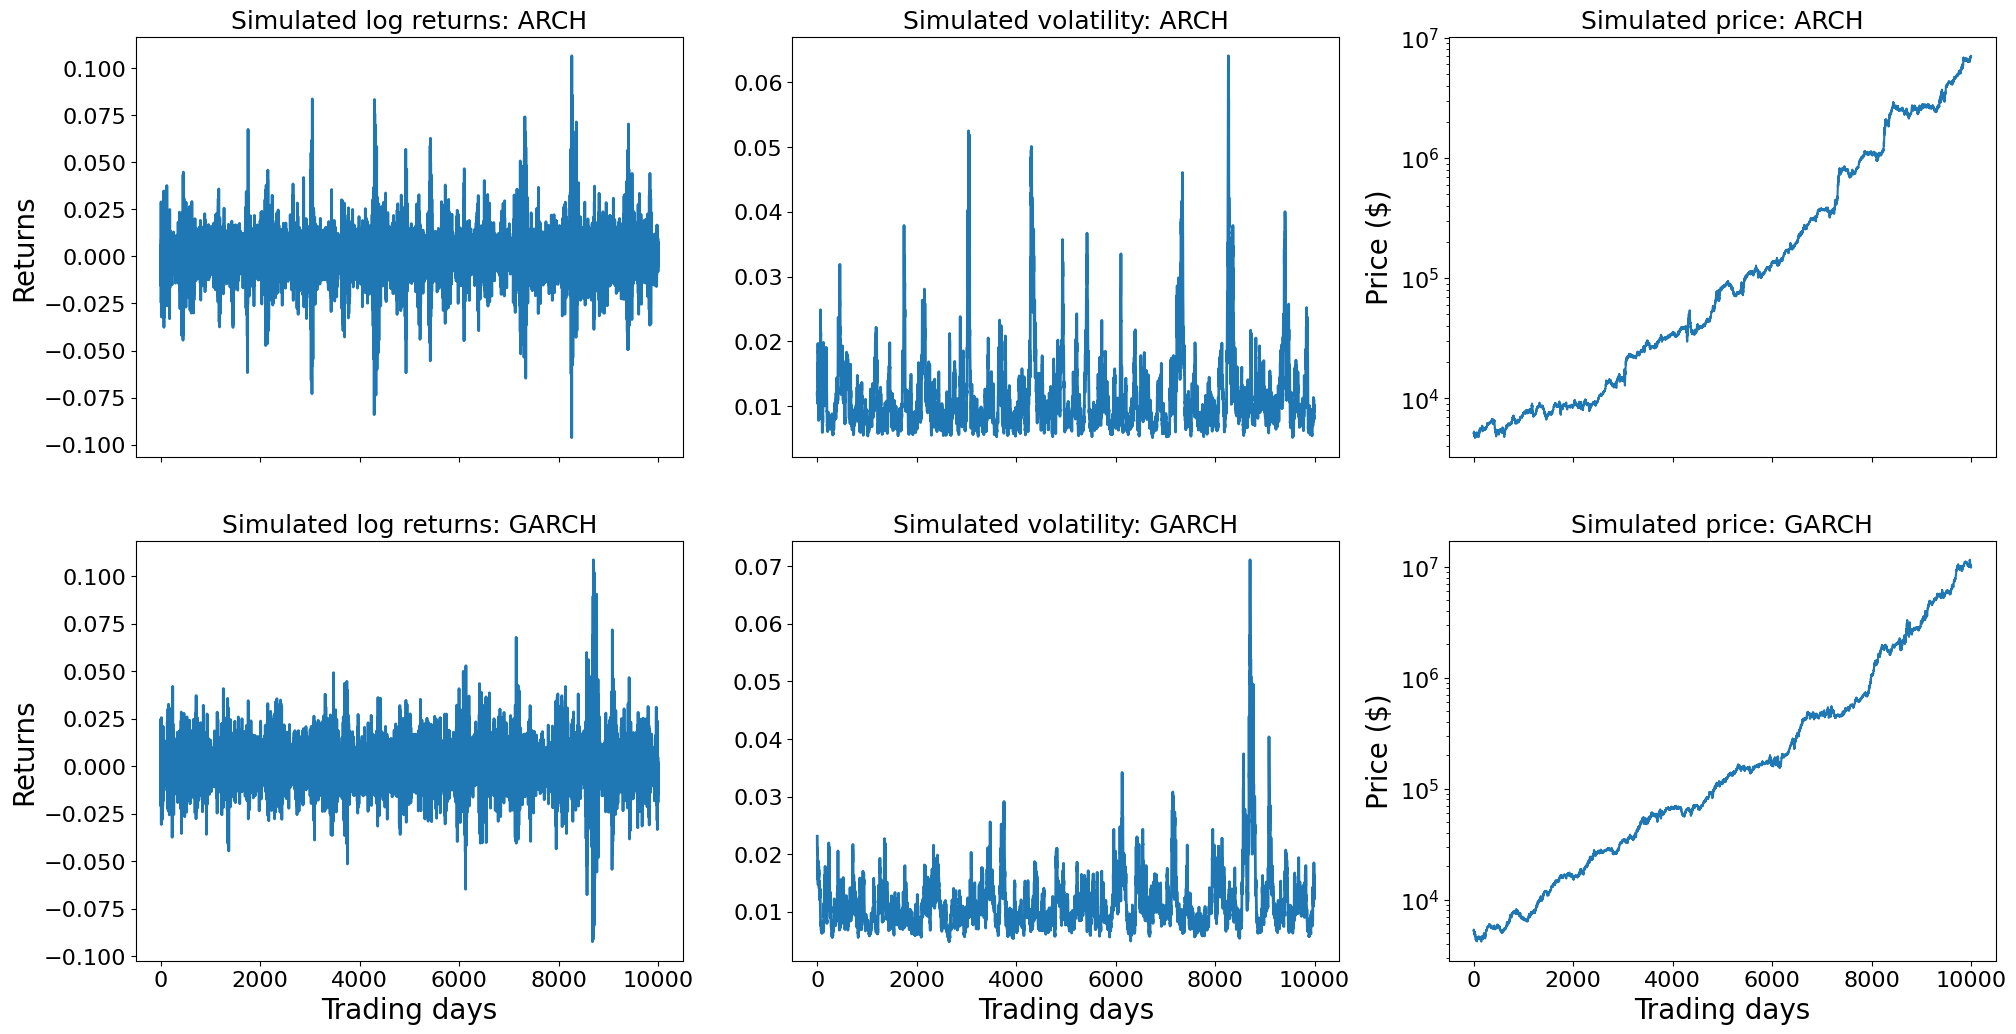

In [103]:
# We plot all the stuff
fig, ax = plt.subplot_mosaic("""ABC
                                DEF""", figsize=(8*3,6*2))
# Returns from ARCH
sim_arch.data.plot(ax=ax['A'], lw=2, sharex=True)
ax['A'].set_title('Simulated log returns: ARCH')
ax['A'].set_ylabel('Returns')

# Volatility from ARCH
sim_arch.volatility.plot(ax=ax['B'], lw=2, label='volatility')
ax['B'].set_title('Simulated volatility: ARCH')

# Price prediction from ARCH
S_t_arch.plot(ax=ax['C'], label='price')
ax['C'].set_yscale('log')
ax['C'].set_ylabel('Price ($)')
ax['C'].set_title('Simulated price: ARCH')

# Returns from GARCH
sim_garch.data.plot(ax=ax['D'], lw=2, label='log returns')
ax['D'].set_title('Simulated log returns: GARCH')
ax['D'].set_xlabel('Trading days')
ax['D'].set_ylabel('Returns')

# Volatility from GARCH
sim_garch.volatility.plot(ax=ax['E'], lw=2, label='volatility')
ax['E'].set_title('Simulated volatility: GARCH')
ax['E'].set_xlabel('Trading days')

# Price prediction from GARCH
S_t_garch.plot(ax=ax['F'], label='price')
ax['F'].set_yscale('log')
ax['F'].set_title('Simulated price: GARCH')
ax['F'].set_ylabel('Price ($)')
ax['F'].set_xlabel('Trading days')
plt.show()

**3. Plot different realisations of the future simulated prices**

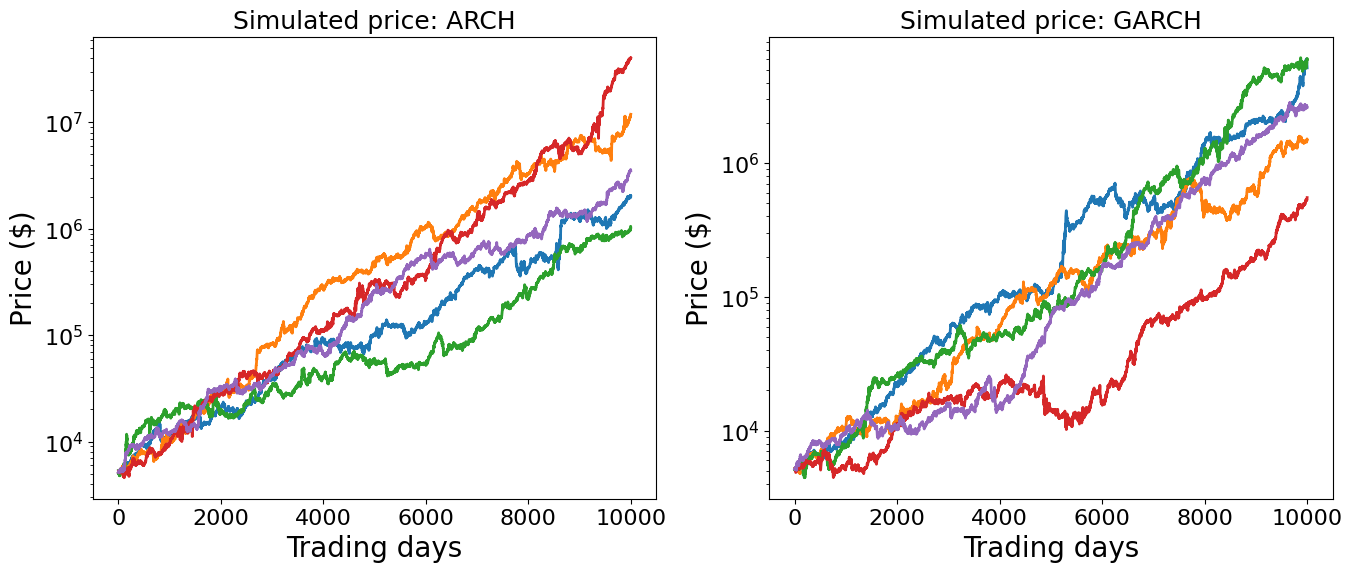

Number of simulations: 5


In [108]:
# Put the simulating process in a loop
realizations = 5
fig, ax = plt.subplot_mosaic("""AB""", figsize=(8*2,6))
for i in range(realizations):
  sim_arch = arch_model(None, p=11, o=0, q=0).simulate(params_arch, N_steps) / 100
  sim_garch = arch_model(None, p=2, o=0, q=2).simulate(params_garch, N_steps) / 100
  S_0 = df.iloc[-1]["Adj Close"]
  S_t_arch = S_0*np.exp(np.cumsum(sim_arch['data']))      # We convert the simulated returns data into prices
  S_t_garch = S_0*np.exp(np.cumsum(sim_garch['data']))
  # ARCH simulation plot
  S_t_arch.plot(ax=ax['A'], lw=2)
  # GARCH simulation plot
  S_t_garch.plot(ax=ax['B'], lw=2)

ax['A'].set_yscale('log')
ax['A'].set_ylabel('Price ($)')
ax['A'].set_title('Simulated price: ARCH')
ax['A'].set_xlabel('Trading days')
ax['B'].set_yscale('log')
ax['B'].set_title('Simulated price: GARCH')
ax['B'].set_ylabel('Price ($)')
ax['B'].set_xlabel('Trading days')
plt.show()
print(f"Number of simulations: {realizations}")

**4. Plot the return distribution of the data (S&P 500), and the ones simulated with the ARCH and GARCH models**

Text(0.5, 0, 'Date')

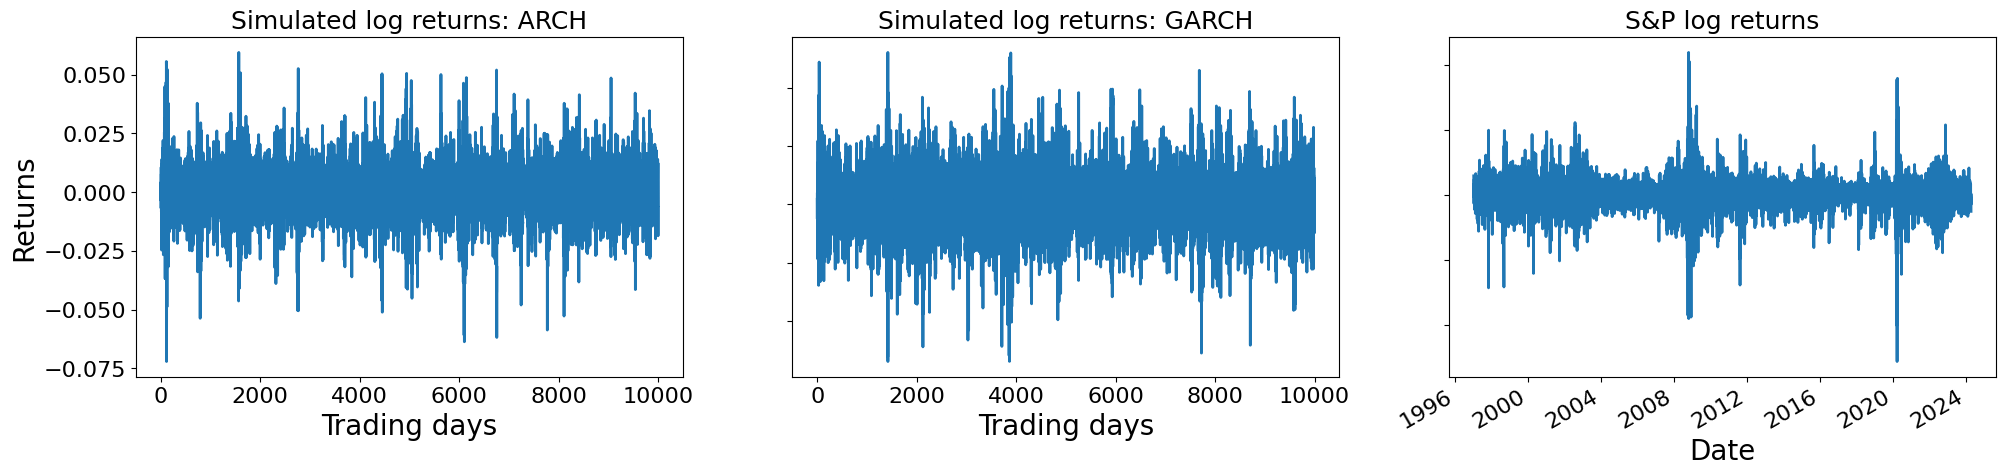

In [109]:
#CODE
fig, ax = plt.subplot_mosaic("""ABC""", figsize=(8*3,5))

# Returns from ARCH
sim_arch.data.plot(ax=ax['A'], lw=2, sharey=True)
ax['A'].set_title('Simulated log returns: ARCH')
ax['A'].set_xlabel('Trading days')
ax['A'].set_ylabel('Returns')

# Returns from GARCH
sim_garch.data.plot(ax=ax['B'], lw=2)
ax['B'].set_title('Simulated log returns: GARCH')
ax['B'].set_xlabel('Trading days')


# Returns from ^GSPC
df['LogRet'].dropna().plot(ax=ax['C'], lw=2)
ax['C'].set_title('S&P log returns')
ax['C'].set_xlabel('Date')
